### 그래프 한글 안 깨지게 하는 코드

In [ ]:
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt

font_files = font_manager.findSystemFonts(fontpaths='/content/drive/MyDrive/Pal-ette/D2Coding')
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rc('font', family='D2Coding')

### 모듈 불러오기


In [ ]:
# !pip install split-folders


In [ ]:
import tensorflow as tf
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, AveragePooling2D, concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping # 모델 저장, 조기종료

import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

# import splitfolders


### 데이터 압축풀기

In [ ]:
!unzip -q "/content/drive/MyDrive/CV_project/data/안구질환/개_train_test_val_augmentation.zip"


In [ ]:
# splitfolders.ratio('/content/개_안구_squared', output='개_train_test_val_squared', ratio=(0.8, 0.1, 0.1))  # train/val/test = 8:1:1


Copying files: 109885 files [00:14, 7461.68 files/s]


In [ ]:
# prompt: /content/개_train_test_val_squared  경로의 파일을 /content/drive/MyDrive/CV_project/data/안구질환 이 경로의 드라이브에 저장하는 코드 알려줘

# !cp -a /content/개_train_test_val_squared /content/drive/MyDrive/CV_project/data/안구질환


### 하이퍼파라미터 설정



In [ ]:
batch_size = 32
img_size = 224
learning_rate = 5e-4
epochs = 30


classes_labels= [
    '결막염',
    '궤양성각막질환',
    '백내장',
    '비궤양성각막질환',
    '색소침착성각막염',
    '안검내반증'
    '안검염',
    '안검종양',
    '유루증',
    '정상',
    '핵경화',
]

num_classes = len(classes_labels)
base_dir = '/content/개_train_test_val_squared'

### 이미지 증강

In [ ]:
# 이미지 증강이 적용된 데이터 제너레이터 선언
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1. / 255,          # 이미지 픽셀 값을 0 ~ 1 사이로 정규화
    width_shift_range=0.1,     # 이미지를 가로로 10% 범위 내에서 무작위 이동
    height_shift_range=0.1,    # 이미지를 세로로 10% 범위 내에서 무작위 이동
    zoom_range=0.1,           # 이미지를 10% 범위 내에서 무작위 확대/축소
    horizontal_flip=True,      # 이미지를 좌우로 무작위 반전
)

validation_datagen = ImageDataGenerator(
    rescale=1. / 255,          # 검증 데이터에도 동일한 정규화 적용
)

test_datagen = ImageDataGenerator(
    rescale=1. / 255          # 테스트 데이터에도 동일한 정규화 적용
)

# flow_from_directory: 디렉토리에서 이미지를 불러와 배치 단위로 제공
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),  # 훈련 데이터 디렉토리 경로
    target_size=(img_size, img_size), # 이미지 크기 조정 (224x224)
    batch_size=batch_size,           # 배치 크기 설정 (32)
    class_mode='categorical',        # 다중 클래스 분류이므로 'categorical' 설정
)

validation_generator = validation_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),    # 검증 데이터 디렉토리 경로
    target_size=(img_size, img_size), # 이미지 크기 조정 (224x224)
    batch_size=batch_size,           # 배치 크기 설정 (32)
    class_mode='categorical',        # 다중 클래스 분류이므로 'categorical' 설정
    follow_links=True        # 숨김 파일 무시
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),   # 테스트 데이터 디렉토리 경로
    target_size=(img_size, img_size), # 이미지 크기 조정 (224x224)
    batch_size=batch_size,           # 배치 크기 설정 (32)
    class_mode='categorical'         # 다중 클래스 분류이므로 'categorical' 설정
)


Found 187336 images belonging to 11 classes.
Found 10983 images belonging to 11 classes.
Found 10997 images belonging to 11 classes.


### 이미지 확인

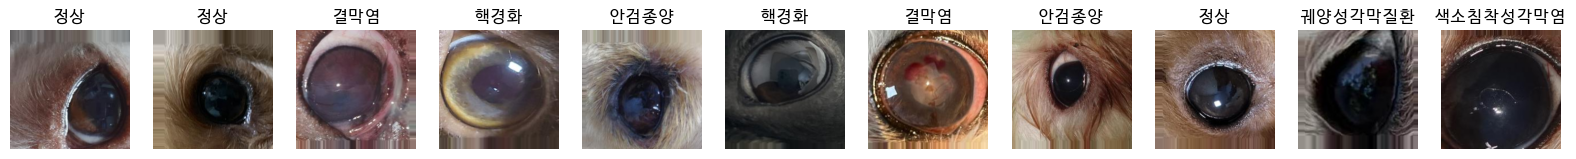

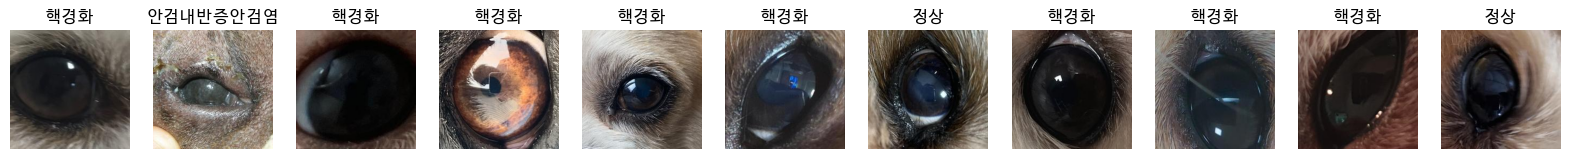

In [ ]:
def show_images(generator, num_images=11):
    image, labels = next(generator)
    plt.figure(figsize=(20, 20))  # 이미지 개수에 따라 figsize 조절

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image[i])

        # 클래스 레이블에 맞는 제목 설정
        class_index = np.argmax(labels[i])  # one-hot encoded labels에서 클래스 인덱스 추출

        # Check if class_index is within the range of classes_labels
        if class_index >= len(classes_labels):
            class_index = 0

        class_name = classes_labels[class_index]
        plt.title(class_name)

        plt.axis('off')
    plt.show()

show_images(train_generator, num_images=11)  # 모든 클래스 이미지 확인
show_images(test_generator, num_images=11)

## 모델 구현
* ResNet50v2 사용


In [ ]:
# 모델 불러오기 및 선언
base_model = tf.keras.applications.ResNet50V2(
    input_shape=(img_size, img_size, 3),  # 입력 이미지 크기 (224x224x3)
    include_top=False,                    # 사전 학습된 모델의 마지막 분류 레이어 제외
    weights='imagenet',                   # ImageNet 데이터셋으로 사전 학습된 가중치 사용
    pooling='avg'                         # 특징 맵을 평균 풀링하여 1차원 벡터로 변환
)

inputs = base_model.input                 # 입력 레이어 설정 (base_model의 입력 사용)
x = tf.keras.layers.Dense(128, activation='relu')(base_model.output)  # 128개 노드의 은닉층 추가 (ReLU 활성화 함수 사용)
x = tf.keras.layers.Dropout(0.1)(x)       # 과적합 방지를 위한 드롭아웃 레이어 추가 (10% 드롭아웃)
outputs = tf.keras.layers.Dense(11, activation='softmax')(x)  # 출력 레이어 설정 (클래스 개수만큼 출력 노드, softmax 활성화 함수 사용)

# 모델 정의
model = tf.keras.Model(inputs=inputs, outputs=outputs)  # 입력과 출력을 연결하여 모델 생성

model.summary()

94668760/94668760 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                             

### 모델 컴파일링


In [ ]:
# ophtimizer 설정
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# 콜백함수
callback = [ReduceLROnPlateau(monitor='val_loss', mode = 'min', factor=0.1, patience=2, min_lr=1e-7, verbose=1),
            ModelCheckpoint('/content/drive/MyDrive/CV_project/안구질환_모델/Resnet_augu_checkpoint.tf', monitor='val_loss', mode='min', save_best_only=True)]
early_stopping_cb = EarlyStopping(patience=4, restore_best_weights=True)  # 과대 적합 방지 및 , 필요하지 않은 훈련 하지 않도록 조기 종료

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

## 모델 학습'


In [11]:
histroy = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[callback, early_stopping_cb]
)

Epoch 1/30
5855/5855 [==============================] - 1974s 332ms/step - loss: 0.7939 - accuracy: 0.6747 - val_loss: 0.3743 - val_accuracy: 0.8535 - lr: 5.0000e-04
Epoch 2/30
5855/5855 [==============================] - 1873s 320ms/step - loss: 0.6311 - accuracy: 0.7301 - val_loss: 0.5156 - val_accuracy: 0.7885 - lr: 5.0000e-04
Epoch 3/30
5855/5855 [==============================] - ETA: 0s - loss: 0.5592 - accuracy: 0.7569
Epoch 3: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.
5855/5855 [==============================] - 1889s 323ms/step - loss: 0.5592 - accuracy: 0.7569 - val_loss: 0.8282 - val_accuracy: 0.6917 - lr: 5.0000e-04
Epoch 4/30
5855/5855 [==============================] - 1915s 327ms/step - loss: 0.4484 - accuracy: 0.7946 - val_loss: 0.3005 - val_accuracy: 0.8738 - lr: 5.0000e-05
Epoch 5/30
5855/5855 [==============================] - 1895s 324ms/step - loss: 0.4160 - accuracy: 0.8057 - val_loss: 0.3174 - val_accuracy: 0.8706 - lr: 5.0000e-05
Epoch 

## 평가지표


In [1]:
# 학습 로그 출력
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(13), histroy.history['loss'], label='Train Loss')
plt.plot(range(13), histroy.history['val_loss'], label='Validation Loss')
plt.title('Traning and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.plot(range(30), histroy.history['accuracy'], label='Train Accuracy')
plt.plot(range(30), histroy.history['val_accuracy'], label='Validation Accuracy')
plt.title('Traning and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

NameError: name 'plt' is not defined

In [ ]:
trained_model = tf.keras.models.load_model('/content/drive/MyDrive/CV_project/안구질환_모델/Resnet_squared_checkpoint.tf')

trained_model.evaluate(test_generator)

344/344 [==============================] - 18s 50ms/step - loss: 0.2558 - accuracy: 0.8931


[0.25583580136299133, 0.8930617570877075]

In [ ]:
# prompt: /content/drive/MyDrive/CV_project/안구질환_모델/ 이 경로의 모델을 저장하는 코드 알려줘

model.save('/content/drive/MyDrive/CV_project/안구질환_모델/Resnet_squared_e30_b32_model.tf')


In [ ]:
!ㅔpip install onnx

In [ ]:
# prompt: onnx 파일로 저장하는 법 알려줘

# Convert the Keras model to ONNX format
import tf2onnx
onnx_model, _ = tf2onnx.convert.from_keras(model)

# Save the ONNX model to a file
with open("/content/drive/MyDrive/CV_project/안구질환_모델/Resnet_squared_e30_b32_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())
